**IMPORTING LIBRARIES**

In [0]:
import numpy as np # linear algebra
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.preprocessing  import image

**IMAGE PLOTS**

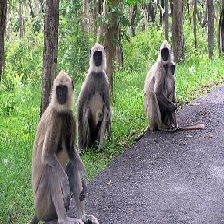

In [0]:
img_path = 'training/n9/n9014.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img

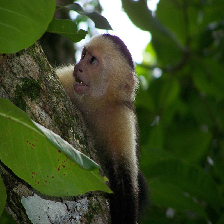

In [0]:

img_path = 'training/n5/n5018.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img

**IMPORTING DATASET**

In [0]:
from zipfile import ZipFile
file_name  = "10-monkey-species.zip"

with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print('Done')

Done


**Training and Validation files uploaded**

**Defining PATH**

In [0]:
from zipfile import ZipFile
file_name  = "training.zip"

with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print('Done')

Done


**TRAIN AND TEST PATH**

In [0]:
from zipfile import ZipFile
file_name  = "validation.zip"

with ZipFile(file_name,"r") as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
train_dir =  'training'
val_dir  =  'validation'

**CHECKING NUMBER OF CLASSES IN THE DATASET**

In [0]:
labels = pd.read_csv("monkey_labels.txt")
num_classes = labels['Label'].size
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


**INPUT PARAMETERS**

In [0]:
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 300

****DATA GENERATOR**

Keras uses a so-called data-generator for inputting data into the neural network, which will loop over the data for eternity.
**

****Data Generator for Train and Test with NO TRANSFORMATIONS****

In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input


## use inception's own preprocess function
train_data_gen_aug=ImageDataGenerator(
                              preprocessing_function=preprocess_input,
                              rotation_range=35,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              horizontal_flip=True,
                              fill_mode='nearest' #default
                              
                             )

validation_data_gen=ImageDataGenerator(
                                       preprocessing_function=preprocess_input
                                      )

****Batch_Size ****

Data Generators processes and returns  images in batches.

Batch sizes should be small for faster processing

In [0]:
train_gen=train_data_gen_aug.flow_from_directory(train_dir,
                                            target_size=(IMAGE_WIDTH,
                                                       IMAGE_HEIGHT),
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            class_mode="categorical")
val_gen = validation_data_gen.flow_from_directory(val_dir, 
                                                    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
                                                    batch_size = BATCH_SIZE, 
                                                    
                                                    class_mode="categorical")

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [0]:
train_count=1097#train_size
val_count=272#test_size

**IMPORTING INCEPTION V3 PRETRAINED WEIGHTS **

In [0]:
from google.colab import files

In [0]:
uploaded = files.upload()

Saving inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 to inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


**MODEL SETUP**

In [0]:
InceptionV3_model=InceptionV3(include_top=False, 
                      pooling='avg', 
                      weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
                     )

We can see that the last layer in the  convolutional layer is is GlobalAveragePooling2D

We wiil be building our Transfer Learning model on top of this layer 


Adding 1 layer of FULLY ONNECTED LAYER with Drop-out and

a classification layer with softmax with  10 output classses

In [0]:
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# set  up the model
model=Sequential()
# add inception pretrained model, the wieghts 80Mb
model.add(InceptionV3(include_top=False, 
                      pooling='avg', 
                      weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
                     ))
# use relu as activation function "vanishing gradiends" :)
model.add(Dense(512, activation="relu"))  
# add drop out to avoid overfitting
model.add(Dropout(0.5))#Dropping a neuron with 0.5 probability gets the highest variance for this distribution. 
model.add(Dense(num_classes, activation="softmax"))

Using dropout layer to minimize overfitting


Dropout(0.5) --------Dropping a neuron with 0.5 probability gets the highest variance for this distribution

**FREEZING THE PRETRAINED LAYER**

In [0]:
# do not need to train the pre train layer
model.layers[0].trainable=False

****SUMMARY OF TENSORS FLOWING b/w  the VGG_16 Layers****

In [0]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 22,857,002
Trainable params: 1,054,218
Non-trainable params: 21,802,784
_________________________________________________________________


****COMPILING MODEL****

In [0]:
# from keras import optimizers
# adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)
# use adam to avoid overfitting

model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

**TRAIN MODEL**

In [0]:
model_history = model.fit_generator(train_gen,
                                    steps_per_epoch=5,
                                    epochs=5,
                                    validation_data=val_gen,
                                    validation_steps=val_count // BATCH_SIZE
                                   )

Epoch 1/5
5/5 [==============================] - 28s 6s/step - loss: 2.6339 - acc: 0.1750 - val_loss: 1.7890 - val_acc: 0.5530
Epoch 2/5
5/5 [==============================] - 13s 3s/step - loss: 2.2294 - acc: 0.2917 - val_loss: 1.3433 - val_acc: 0.7097
Epoch 3/5
5/5 [==============================] - 15s 3s/step - loss: 1.8078 - acc: 0.4333 - val_loss: 1.0429 - val_acc: 0.7742
Epoch 4/5
5/5 [==============================] - 12s 2s/step - loss: 1.3431 - acc: 0.5500 - val_loss: 0.8818 - val_acc: 0.7419
Epoch 5/5
5/5 [==============================] - 14s 3s/step - loss: 1.0519 - acc: 0.7083 - val_loss: 0.6634 - val_acc: 0.8548


****ACCURACY and ERROR PLOT****

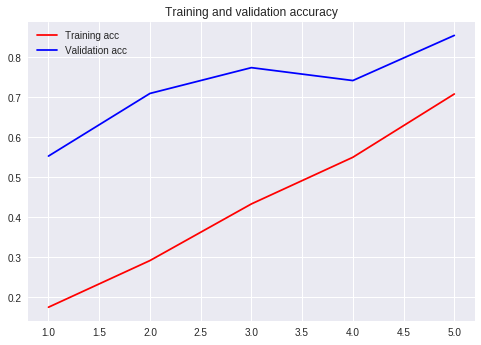

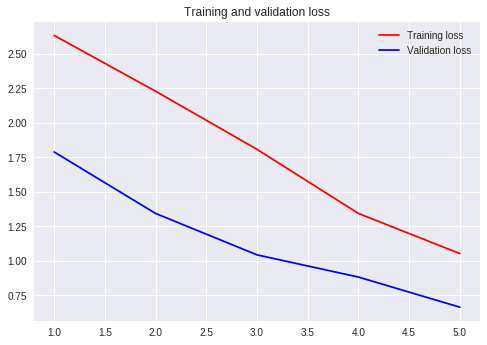

In [0]:
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

****DATA AUGMENTATION****

**We have a small training-set so it helps to artificially inflate its size by making various transformations to the images. We use a built-in data-generator that can make these random transformations.**

**** DATA GENERATOR FOR TRAIN****

In [0]:
train_data_gen_aug=ImageDataGenerator(
                              preprocessing_function=preprocess_input,
                              rotation_range=180,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.1,
                              horizontal_flip=True,
                              fill_mode='nearest'
                              
                             )

****DATA GENERATOR FOR TEST with no Transformations**

   No transformations should be performed on the test set since we to predict the exact classification accuarcy on these images
    **

In [0]:
validation_data_gen=ImageDataGenerator(
                                       preprocessing_function=preprocess_input
                                      )

In [0]:
train_gen_aug=train_data_gen_aug.flow_from_directory(train_dir,
                                            target_size=(IMAGE_WIDTH,
                                                       IMAGE_HEIGHT),
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            class_mode="categorical")
val_gen_aug = validation_data_gen.flow_from_directory(val_dir, 
                                                    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
                                                    batch_size = BATCH_SIZE, 
                                                    
                                                    class_mode="categorical")

Found 1097 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [0]:
model_aug=Sequential()
# add inception pretrained model, the wieghts 80Mb
model_aug.add(InceptionV3(include_top=False, 
                      pooling='avg', 
                      weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
                     ))
# use relu as activation function "vanishing gradiends" :)
model_aug.add(Dense(512, activation="relu"))  
# add drop out to avoid overfitting
model_aug.add(Dropout(0.5))
model_aug.add(Dense(num_classes, activation="softmax"))

****FREEZING Pretrained Layers****

In [0]:
model_aug.layers[0].trainable=False


In [0]:
model_aug.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
Total params: 22,857,002
Trainable params: 1,054,218
Non-trainable params: 21,802,784
_________________________________________________________________


**COMPILE MODEL**

In [0]:
model_aug.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

****TRANING MODEL****

In [0]:
model_aug_history = model_aug.fit_generator(train_gen_aug,
                                    steps_per_epoch=5,
                                    epochs=5,
                                    validation_data=val_gen_aug,
                                    validation_steps=val_count // BATCH_SIZE
                                   )

Epoch 1/5
5/5 [==============================] - 33s 7s/step - loss: 2.6860 - acc: 0.1250 - val_loss: 2.0541 - val_acc: 0.3030
Epoch 2/5
5/5 [==============================] - 13s 3s/step - loss: 2.6108 - acc: 0.0917 - val_loss: 1.6826 - val_acc: 0.5565
Epoch 3/5
5/5 [==============================] - 12s 2s/step - loss: 2.0808 - acc: 0.3083 - val_loss: 1.6794 - val_acc: 0.3266
Epoch 4/5
5/5 [==============================] - 13s 3s/step - loss: 2.0851 - acc: 0.2750 - val_loss: 1.2449 - val_acc: 0.8266
Epoch 5/5
5/5 [==============================] - 13s 3s/step - loss: 1.7822 - acc: 0.4333 - val_loss: 1.1111 - val_acc: 0.8790


****ACCURACY and ERROR PLOT****

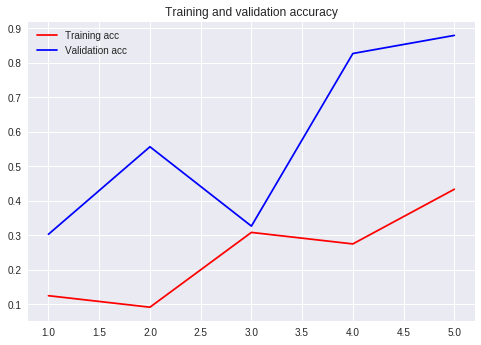

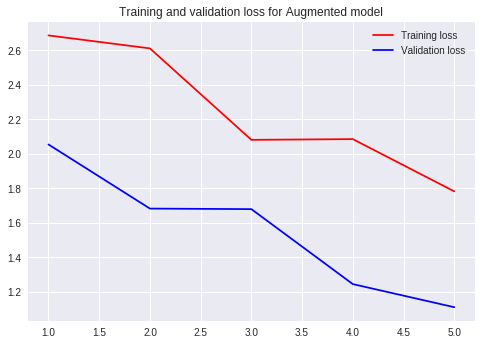

In [0]:
acc =  model_aug_history.history['acc']
val_acc = model_aug_history.history['val_acc']
loss = model_aug_history.history['loss']
val_loss = model_aug_history.history['val_loss']
epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss for Augmented model')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

****Removing Drop-out Layer****

We will accessing performance  by removing the dropout layer  on the basis of validation accuracy

**We will accessing performance  by removing the dropout layer  on the basis of validation accuracy**

In [0]:
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# set  up the model
model_NoDropOut=Sequential()
# add inception pretrained model, the wieghts 80Mb
model_NoDropOut.add(InceptionV3(include_top=False, 
                      pooling='avg', 
                      weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
                     ))
# use relu as activation function "vanishing gradiends" :)
model_NoDropOut.add(Dense(512, activation="relu"))  
# add drop out to avoid overfitting
#model_NoDropOut.add(Dropout(0.5))
model_NoDropOut.add(Dense(num_classes, activation="softmax"))

**FREEZING PRETRAINED LAYERS**

In [0]:
# do not need to train the pre train layer
model_NoDropOut.layers[0].trainable=False

In [0]:
model_NoDropOut.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_7 (Dense)              (None, 10)                5130      
Total params: 22,857,002
Trainable params: 1,054,218
Non-trainable params: 21,802,784
_________________________________________________________________


****COMPILE MODEL****

In [0]:
# from keras import optimizers
# adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)
# use adam to avoid overfitting

model_NoDropOut.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

**TRAIN MODEL**

In [0]:
model_NoDropOut_history = model_NoDropOut.fit_generator(train_gen,
                                    steps_per_epoch=5,
                                    epochs=5,
                                    validation_data=val_gen,
                                    validation_steps=val_count // BATCH_SIZE
                                   )

Epoch 1/5
5/5 [==============================] - 36s 7s/step - loss: 2.5695 - acc: 0.1750 - val_loss: 2.1208 - val_acc: 0.3427
Epoch 2/5
5/5 [==============================] - 13s 3s/step - loss: 2.0638 - acc: 0.3203 - val_loss: 1.2495 - val_acc: 0.6492
Epoch 3/5
5/5 [==============================] - 12s 2s/step - loss: 1.4218 - acc: 0.5833 - val_loss: 1.0437 - val_acc: 0.7056
Epoch 4/5
5/5 [==============================] - 12s 2s/step - loss: 1.1424 - acc: 0.6750 - val_loss: 0.8482 - val_acc: 0.7258
Epoch 5/5
5/5 [==============================] - 11s 2s/step - loss: 0.8925 - acc: 0.7000 - val_loss: 0.5929 - val_acc: 0.8024


****ACCURACY and ERROR PLOT****

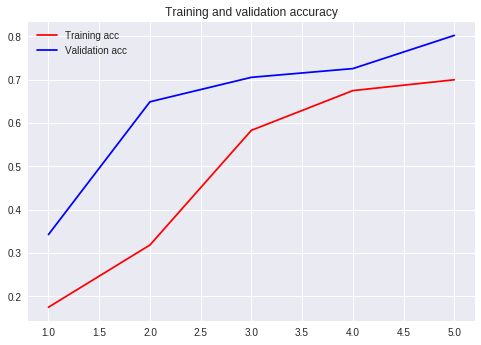

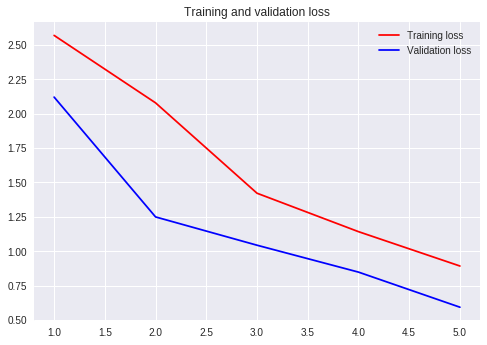

In [0]:
acc = model_NoDropOut_history.history['acc']
val_acc = model_NoDropOut_history.history['val_acc']
loss = model_NoDropOut_history.history['loss']
val_loss = model_NoDropOut_history.history['val_loss']
epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

**Add 1 more Fully Connected Layer**

In [0]:
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# set  up the model
model_FC=Sequential()
# add inception pretrained model, the wieghts 80Mb
model_FC.add(InceptionV3(include_top=False, 
                      pooling='avg', 
                      weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
                     ))
# use relu as activation function "vanishing gradiends" :)
model_FC.add(Dense(512, activation="relu"))  
# add drop out to avoid overfitting
model_FC.add(Dropout(0.5))#Dropping a neuron with 0.5 probability gets the highest variance for this distribution. 
model_FC.add(Dense(512, activation="relu"))  
# add drop out to avoid overfitting
model_FC.add(Dropout(0.5))
model_FC.add(Dense(num_classes, activation="softmax"))

**FREEZING PRETRAINED LAYERS**

In [0]:
# do not need to train the pre train layer
model_FC.layers[0].trainable=False

In [0]:
model_FC.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                5130      
Total params: 23,119,658
Trainable params: 1,316,874
Non-trainable params: 21,802,784
________________________________________________________

**COMPILE MODEEL**

In [0]:
# from keras import optimizers
# adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)
# use adam to avoid overfitting

model_FC.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

**TRAIN MODEL**

In [0]:
model_FC_history = model_FC.fit_generator(train_gen,
                                    steps_per_epoch=5,
                                    epochs=5,
                                    validation_data=val_gen,
                                    validation_steps=val_count // BATCH_SIZE
                                   )

Epoch 1/5
5/5 [==============================] - 13s 3s/step - loss: 1.8722 - acc: 0.3333 - val_loss: 1.2364 - val_acc: 0.8427
Epoch 2/5
5/5 [==============================] - 14s 3s/step - loss: 1.6861 - acc: 0.4500 - val_loss: 1.1604 - val_acc: 0.8295
Epoch 3/5
5/5 [==============================] - 14s 3s/step - loss: 1.5905 - acc: 0.5083 - val_loss: 0.9423 - val_acc: 0.8790
Epoch 4/5
5/5 [==============================] - 13s 3s/step - loss: 1.4230 - acc: 0.5000 - val_loss: 0.8076 - val_acc: 0.7903
Epoch 5/5
5/5 [==============================] - 14s 3s/step - loss: 1.1965 - acc: 0.6083 - val_loss: 0.7399 - val_acc: 0.8105


****ACCURACY and ERROR PLOT****

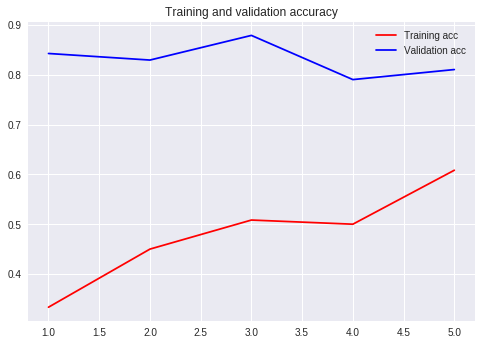

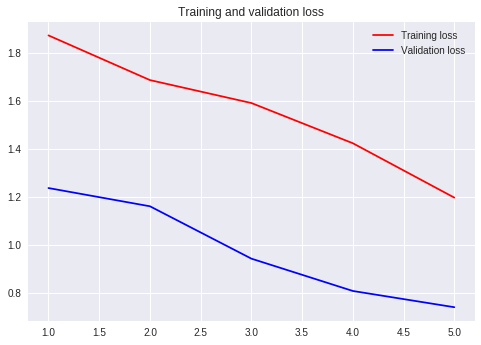

In [0]:
acc = model_FC_history.history['acc']
val_acc = model_FC_history.history['val_acc']
loss = model_FC_history.history['loss']
val_loss = model_FC_history.history['val_loss']
epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

**Varying Nodes in FC layers**

In [0]:
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# set  up the model
model4=Sequential()
# add inception pretrained model, the wieghts 80Mb
model4.add(InceptionV3(include_top=False, 
                      pooling='avg', 
                      weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
                     ))
# use relu as activation function "vanishing gradiends" :)
model4.add(Dense(512, activation="relu"))  
# add drop out to avoid overfitting
model4.add(Dropout(0.5))
model4.add(Dense(256, activation="relu"))  
# add drop out to avoid overfitting
model4.add(Dropout(0.5))#Dropping a neuron with 0.5 probability gets the highest variance for this distribution. 
model4.add(Dense(num_classes, activation="softmax"))

In [0]:
# do not need to train the pre train layer
model4.layers[0].trainable=False

In [0]:
model4.layers[0].summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_659 (Conv2D)             (None, None, None, 3 864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_659 (BatchN (None, None, None, 3 96          conv2d_659[0][0]                 
__________________________________________________________________________________________________
activation_659 (Activation)     (None, None, None, 3 0           batch_normalization_659[0][0]    
__________________________________________________________________________________________________
conv2d_660

In [0]:
model4.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_11 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 22,985,770
Trainable params: 1,182,986
Non-trainable params: 21,802,784
________________________________________________________

In [0]:
# from keras import optimizers
# adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)
# use adam to avoid overfitting

model4.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [0]:
model4_history = model4.fit_generator(train_gen,
                                    steps_per_epoch=5,
                                    epochs=5,
                                    validation_data=val_gen,
                                    validation_steps=val_count // BATCH_SIZE
                                   )

Epoch 1/5
5/5 [==============================] - 50s 10s/step - loss: 2.6713 - acc: 0.0917 - val_loss: 2.0193 - val_acc: 0.3387
Epoch 2/5
5/5 [==============================] - 10s 2s/step - loss: 2.6972 - acc: 0.1750 - val_loss: 1.8303 - val_acc: 0.5524
Epoch 3/5
5/5 [==============================] - 10s 2s/step - loss: 2.4647 - acc: 0.2000 - val_loss: 1.7841 - val_acc: 0.6855
Epoch 4/5
5/5 [==============================] - 14s 3s/step - loss: 2.1705 - acc: 0.2167 - val_loss: 1.7280 - val_acc: 0.5806
Epoch 5/5
5/5 [==============================] - 11s 2s/step - loss: 2.1459 - acc: 0.2333 - val_loss: 1.5238 - val_acc: 0.6653


**ACCURACY and ERROR PLOT**

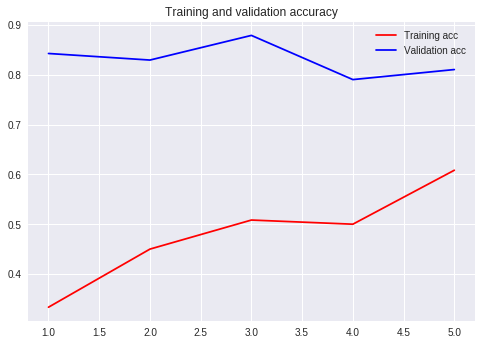

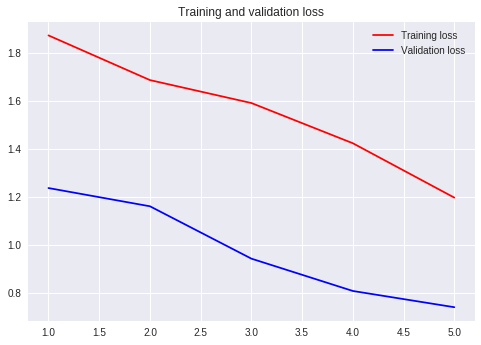

In [0]:
acc = model_FC_history.history['acc']
val_acc = model_FC_history.history['val_acc']
loss = model_FC_history.history['loss']
val_loss = model_FC_history.history['val_loss']
epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()